# Get NDVI data using openEO

The Normalised Difference Vegetation Index (NDVI) is a proxy to quantify the vegetation amount. It is defined as NDVI=(NIR-Red)/(NIR+Red) where NIR corresponds to the reflectance in the near infrared band, and Red to the reflectance in the red band.

There are several ways to access and compute NDVI data using the openEO API in the Copernicus Data Space Ecosystem (CDSE). In this notebook, we will demonstrate two main approaches: (i) accessing the operational NDVI product and (ii) computing NDVI from Sentinel 2 L2A using openEO processes.

All processing is executed in the cloud on the CDSE infrastructure using openEO API, so no local data download or heavy computation is required. Therefore, if you don't yet have an account on CDSE, please register at [https://dataspace.copernicus.eu](https://dataspace.copernicus.eu)


In this notebook, you will learn how to:
* Connect to the CDSE openEO federation backend
* Directly access the [Copernicus Global Land Service](https://land.copernicus.eu/en/products/vegetation) NDVI collection hosted by [Terrascope](https://documentation.dataspace.copernicus.eu/APIs/openEO/federation/openeo_federation.html#terrascope)
* Compute NDVI from Sentinel 2 L2A using openEO processes
* Run EO processing workflows entirely in the cloud and download only the final results

Prerequisites
* A CDSE account (register at https://dataspace.copernicus.eu)
* Basic familiarity with Python and Earth Observation data 

## Introduction

Before we jump into the practical steps, let's briefly understand what is openEO and the concepts involved in accessing NDVI data.

### What is openEO?

openEO is an open-source standard that simplifies access to and processing of Earth Observation (EO) data.
Instead of downloading and processing large satellite datasets locally, openEO allows users to:
* Access EO data directly where it is stored
* Run scalable processing workflows in the cloud
* Save workflows as User-Defined Processes (UDPs) for reuse
* Reshare and reuse UDPs as services

This enables faster, more reproducible, and easier-to-scale EO data analysis.

### openEO workflows

Before diving into practical steps, it is useful to understand the general structure of an openEO workflow.

Most openEO workflows follow the same high-level pattern:
1. Connect to an openEO backend
2. Load collection for a specific spatial and temporal extent
3. Build a processing workflow (also called a *process graph*) using openEO processes
4. Execute the workflow on the backend

For a full introduction to these concepts, please refer to the official openEO *Getting Started* notebook:  
https://github.com/Open-EO/openeo-community-examples/blob/main/python/1.%20GettingStarted/GettingStarted.ipynb|

Let's get started by installing the required Python package.

## Installation

The only package required to run this service is the `openeo` Python client, which can be installed via pip:

```

pip install openeo

```

In [2]:
import openeo

Next, let's set up a connection to an openEO backend, in this case the Copernicus Data Space Ecosystem (CDSE) federation. 

*Don't get confused by the term "federation" here; it simply is referring to a group service providers in the ecosystem. Since are interested in collection hosted by Terrascope, we are using the federation endpoint. To connect to CDSE backend use "openeo.dataspace.copernicus.eu"* 

For more information visit:
* [Documentation](https://documentation.dataspace.copernicus.eu/APIs/openEO/federation/openeo_federation.html)
* [Federated processing example](https://github.com/Open-EO/openeo-community-examples/blob/main/python/Federation/FederatedProcessing.ipynb)


You can authenticate using your credentials as shown below.

In [4]:
connection = openeo.connect("openeofed.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


### Method 1: Accessing operational NDVI product from Copernicus Global Land Service

The first method demonstrates how to load the global NDVI product, CGLS_NDVI_V2_GLOBAL. Let us first identify the available collection for the NDVI product. We can do this by listing all available collections and filtering for those related to NDVI.

In [5]:
collections = connection.list_collections()

for collection in collections:
    title = collection.get("title", "")
    cid = collection.get("id", "")
    if "NDVI" in title or "NDVI" in cid:
        print(f"ID: {cid}, Title: {title}")


ID: CGLS_NDVI300_V2_GLOBAL, Title: Copernicus Global Land NDVI product V2, 300m resolution, 10-daily
ID: SENTINEL3_SYNERGY_VG1, Title: Sentinel-3 Level 2 Synergy 1 km VEGETATION-Like daily synthesis TOC reflectance and NDVI  - V1
ID: SENTINEL3_SYNERGY_VG10, Title: Sentinel-3 Level 2 Synergy 1 km VEGETATION-Like 10-daily synthesis TOC reflectance and NDVI  - V1
ID: TERRASCOPE_S2_NDVI_V2, Title: Sentinel-2 NDVI last 2 years over Europe + selected areas, by Terrascope.
ID: CGLS_NDVI_LTS_V2_GLOBAL, Title: Copernicus Global Land NDVI Long term statistics product V2, 1km resolution, 10-daily
ID: CGLS_NDVI_LTS_V3_GLOBAL, Title: Copernicus Global Land NDVI Long term statistics product V3, 1km resolution, 10-daily
ID: CGLS_NDVI300_V1_GLOBAL, Title: Copernicus Global Land NDVI product V1, 300m resolution, 10-daily
ID: CGLS_NDVI_V3_GLOBAL, Title: Copernicus Global Land NDVI product V3, 1km resolution, 10-daily
ID: CGLS_NDVI_V2_GLOBAL, Title: Copernicus Global Land NDVI product V2, 1km resolution,

In [6]:
connection.describe_collection("CGLS_NDVI_V2_GLOBAL")

{'cube:dimensions': {'bands': {'type': 'bands', 'values': ['NDVI']},
  't': {'extent': ['1998-04-01T00:00:00Z', '2021-01-01T00:00:00Z'],
   'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180.00446428571428, 179.9955357],
   'reference_system': 4326,
   'step': 0.0089285714,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-59.9955357, 80.0044643],
   'reference_system': 4326,
   'step': 0.0089285714,
   'type': 'spatial'}},
 'description': 'Global NDVI at 1km resolution, 10-daily. The Normalized Difference Vegetation Index (NDVI) is an indicator of the greenness of the biomes. As such, it is closely linked to the FAPAR.',
 'extent': {'spatial': {'bbox': [[-180.00446428571428,
     -59.9955357,
     179.9955357,
     80.0044643]]},
  'temporal': {'interval': [['1998-04-01T00:00:00Z',
     '2021-01-01T00:00:00Z']]}},
 'id': 'CGLS_NDVI_V2_GLOBAL',
 'license': 'free',
 'links': [{'href': 'https://land.copernicus.eu/global/products/ndvi',
   'rel': 'alternate',
   'title': 'Product web page.'},
  {'href': 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/collections',
   'rel': 'root'},
  {'href': 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/collections',
   'rel': 'parent'},
  {'href': 'https://openeofed.dataspace.copernicus.eu/openeo/1.2/collections/CGLS_NDVI_V2_GLOBAL',
   'rel': 'self'}],
 'stac_extensions': ['https://stac-extensions.github.io/datacube/v2.2.0/schema.json',
  'https://stac-extensions.github.io/eo/v1.1.0/schema.json'],
 'stac_version': '0.9.0',
 'summaries': {'federation:backends': ['terrascope']},
 'title': 'Copernicus Global Land NDVI product V2, 1km resolution, 10-daily'}

Copernicus Global Land NDVI V2 provides global NDVI data at 1km spatial resolution and 10-day temporal resolution covering the period from 1998 to December 2020 from SPOT/VEGETATION and PROBA-V data. Detailed product information, including scientific background, algorithm description, and validation reports, is available on the Copernicus Land Monitoring Service vegetation products webpage at https://land.copernicus.eu/en/products/vegetation.

In the following cell, we load the NDVI collection for a specific area of interest and temporal extent.

In [7]:
ndvi_1km = connection.load_collection(
    "CGLS_NDVI_V2_GLOBAL",
    temporal_extent=["2019-01-01", "2019-02-01"],
    spatial_extent={"west": 5.215759, "south": 51.160296, "east": 5.405960, "north": 51.244815},
    bands=["NDVI"],
)

As openEO follows a lazy execution model, no processing is done yet. We have just defined the data we want to work with. As a user you can now build more complex processing workflows using openEO processes. Advance usecases using openEO for EO data processing can be found in the [openEO community examples repository](https://github.com/Open-EO/openeo-community-examples/tree/main/python)

In this example, we will keep it simple and just create a job to download the data. For more information on openEO batch jobs, please refer to the [openEO documentation](https://open-eo.github.io/openeo-python-client/batch_jobs.html).

In [8]:
job = ndvi_1km.create_job(out_format="GTiff", title="NDVI_1km_Job")
job.start_and_wait()

0:00:00 Job 'terrascope-j-2601271400514e468504f47729179ecc': send 'start'
0:00:11 Job 'terrascope-j-2601271400514e468504f47729179ecc': queued (progress 0%)
0:00:16 Job 'terrascope-j-2601271400514e468504f47729179ecc': queued (progress 0%)
0:00:23 Job 'terrascope-j-2601271400514e468504f47729179ecc': queued (progress 0%)
0:00:31 Job 'terrascope-j-2601271400514e468504f47729179ecc': running (progress 3.8%)
0:00:41 Job 'terrascope-j-2601271400514e468504f47729179ecc': running (progress 5.3%)
0:00:54 Job 'terrascope-j-2601271400514e468504f47729179ecc': running (progress 7.2%)
0:01:10 Job 'terrascope-j-2601271400514e468504f47729179ecc': running (progress 9.3%)
0:01:29 Job 'terrascope-j-2601271400514e468504f47729179ecc': running (progress 11.9%)
0:01:53 Job 'terrascope-j-2601271400514e468504f47729179ecc': finished (progress 100%)


<BatchJob job_id='terrascope-j-2601271400514e468504f47729179ecc'>

Once a batch job is finished you can get a handle to the results (which can be a single file or multiple files) and download them to a local directory.

In [9]:
results = job.get_results()
results.download_files("data/ndvi_1km")

[PosixPath('data/ndvi_1km/openEO_2019-01-01Z.tif'),
 PosixPath('data/ndvi_1km/openEO_2019-01-11Z.tif'),
 PosixPath('data/ndvi_1km/openEO_2019-01-21Z.tif'),
 PosixPath('data/ndvi_1km/job-results.json')]

### Method 2: NDVI computation using openEO processes from Sentinel-2 L2A

The second method presented in this notebook is computing NDVI using the openEO processes from Sentinel-2 Level-2A data offered in CDSE. 

We start by loading the Sentinel-2 L2A collection for a specific area of interest and temporal extent. We then use the `ndvi` process to compute NDVI from the red and near-infrared bands (B4 and B8 respectively). Finally, we create a batch job to execute the workflow and download the results.

In [ ]:
### Method 2: Computing NDVI from Sentinel 2 L2A using openEO processes
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-06-01", "2020-10-01"],
    spatial_extent={"west": 5.215759, "south": 51.160296, "east": 5.405960, "north": 51.244815},
    bands=["B04", "B08"],
)

Calculate the NDVI from the red and NIR bands:

In [12]:
ndvi = s2_cube.ndvi(nir="B08", red="B04")

Though we are using the `ndvi` process here, you can also compute NDVI manually using the `bandmath` process as follows:

```
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)
```
Also, note that you can build more complex workflows by chaining multiple openEO processes together. For more information on available openEO processes, please refer to the [openEO documentation](https://open-eo.github.io/openeo-python-client/index.html).

In [13]:
job = ndvi.create_job(out_format="GTiff", title="NDVI_Job")
job.start_and_wait()

0:00:00 Job 'cdse-j-2601271408374e978f40cd50bd1e2946': send 'start'
0:00:17 Job 'cdse-j-2601271408374e978f40cd50bd1e2946': created (progress 0%)
0:00:23 Job 'cdse-j-2601271408374e978f40cd50bd1e2946': created (progress 0%)
0:00:29 Job 'cdse-j-2601271408374e978f40cd50bd1e2946': created (progress 0%)
0:00:37 Job 'cdse-j-2601271408374e978f40cd50bd1e2946': running (progress N/A)
0:00:47 Job 'cdse-j-2601271408374e978f40cd50bd1e2946': running (progress N/A)
0:01:00 Job 'cdse-j-2601271408374e978f40cd50bd1e2946': running (progress N/A)
0:01:15 Job 'cdse-j-2601271408374e978f40cd50bd1e2946': running (progress N/A)
0:01:35 Job 'cdse-j-2601271408374e978f40cd50bd1e2946': running (progress N/A)
0:02:00 Job 'cdse-j-2601271408374e978f40cd50bd1e2946': running (progress N/A)
0:02:30 Job 'cdse-j-2601271408374e978f40cd50bd1e2946': running (progress N/A)
0:03:08 Job 'cdse-j-2601271408374e978f40cd50bd1e2946': running (progress N/A)
0:03:55 Job 'cdse-j-2601271408374e978f40cd50bd1e2946': finished (progress 100

<BatchJob job_id='cdse-j-2601271408374e978f40cd50bd1e2946'>

In [14]:
results = job.get_results()
results.download_files("data/ndvi")

[PosixPath('data/ndvi/openEO_2020-06-01Z.tif'),
 PosixPath('data/ndvi/openEO_2020-06-04Z.tif'),
 PosixPath('data/ndvi/openEO_2020-06-06Z.tif'),
 PosixPath('data/ndvi/openEO_2020-06-09Z.tif'),
 PosixPath('data/ndvi/openEO_2020-06-11Z.tif'),
 PosixPath('data/ndvi/openEO_2020-06-14Z.tif'),
 PosixPath('data/ndvi/openEO_2020-06-16Z.tif'),
 PosixPath('data/ndvi/openEO_2020-06-19Z.tif'),
 PosixPath('data/ndvi/openEO_2020-06-21Z.tif'),
 PosixPath('data/ndvi/openEO_2020-06-24Z.tif'),
 PosixPath('data/ndvi/openEO_2020-06-26Z.tif'),
 PosixPath('data/ndvi/openEO_2020-06-29Z.tif'),
 PosixPath('data/ndvi/openEO_2020-07-01Z.tif'),
 PosixPath('data/ndvi/openEO_2020-07-04Z.tif'),
 PosixPath('data/ndvi/openEO_2020-07-06Z.tif'),
 PosixPath('data/ndvi/openEO_2020-07-09Z.tif'),
 PosixPath('data/ndvi/openEO_2020-07-11Z.tif'),
 PosixPath('data/ndvi/openEO_2020-07-14Z.tif'),
 PosixPath('data/ndvi/openEO_2020-07-16Z.tif'),
 PosixPath('data/ndvi/openEO_2020-07-19Z.tif'),
 PosixPath('data/ndvi/openEO_2020-07-21Z

## Quick visualization

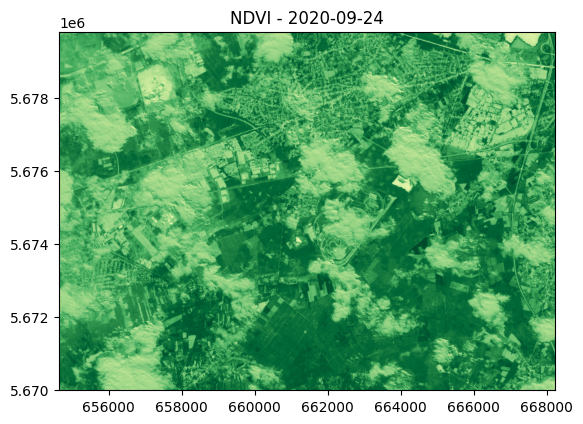

In [15]:
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt

tif_file = "data/ndvi/openEO_2020-09-24Z.tif"

with rasterio.open(tif_file) as src:
    data = src.read(1)
    extent = rasterio.plot.plotting_extent(src)

plt.imshow(data, cmap="YlGn", extent=extent)
plt.title("NDVI - 2020-09-24")
plt.show()


Therefore, by using any of these approaches either the operational Copernicus land product access or simple NDVI computation, user can obtain NDVI data for their area and time of interest. Together, these workflows illustrate how openEO can be used as a unified interface supporting reproducible, scalable land and climate monitoring applications.